In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
tf.get_logger().setLevel('ERROR')

In [2]:
labels_df = pd.read_csv('/kaggle/input/segmentation-dataset/labels_data.csv')
X_train = np.load('/kaggle/input/segmentation-dataset/X_train.npy').astype(np.float32) / 255.0
Y_train = np.load('/kaggle/input/segmentation-dataset/Y_train.npy').astype(np.int32)
X_val = np.load('/kaggle/input/segmentation-dataset/X_val.npy').astype(np.float32) / 255.0
Y_val = np.load('/kaggle/input/segmentation-dataset/Y_val.npy').astype(np.int32)

In [3]:
X_train.dtype, Y_train.dtype, X_val.dtype, Y_val.dtype

(dtype('float32'), dtype('int32'), dtype('float32'), dtype('int32'))

In [4]:
def create_model(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    inputs = layers.Input(shape=(128, 256, 3))

    # CSPNet Branch
    # CSPNet Block 1
    csp1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    split1 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(csp1)
    split2 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(csp1)

    split1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(split1)
    merge1 = layers.Concatenate()([split1, split2])
    csp1_out = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(merge1)

    # CSPNet Block 2
    csp2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(csp1_out)
    split1 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(csp2)
    split2 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(csp2)

    split1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(split1)
    merge2 = layers.Concatenate()([split1, split2])
    csp2_out = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(merge2)

    # CSPNet Block 3
    csp3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(csp2_out)
    split1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(csp3)
    split2 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(csp3)

    split1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(split1)
    merge3 = layers.Concatenate()([split1, split2])
    csp3_out = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(merge3)

    # CSPNet Block 4
    csp4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(csp3_out)
    split1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(csp4)
    split2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(csp4)

    split1 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(split1)
    merge4 = layers.Concatenate()([split1, split2])
    csp4_out = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(merge4)

    # UNet Branch
    c1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    c1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
    c2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
    c3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.3)(p3)

    c4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
    c4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.3)(p4)

    c5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(p4)
    c5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(u6)
    c6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(u7)
    c7 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(u8)
    c8 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(u9)
    c9 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(c9)

    # Merge CSPNet and UNet branches
    merged = layers.Concatenate()([csp4_out, c9])

    # Final output layer
    outputs = layers.Conv2D(29, (1, 1), activation='softmax')(merged)

    # Create model
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [5]:
model = create_model()
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 256,  │      9,248 │ conv2d_20[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 128,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 128,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 32,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 32,    │    590,080 │ conv2d_26[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 16,     │          0 │ conv2d_27[0][0] 

 Total params: 8,875,789 (33.86 MB)

 Trainable params: 8,875,789 (33.86 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
tf.keras.utils.plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='val_loss'
)

history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/200


I0000 00:00:1728247941.680816      79 service.cc:145] XLA service 0x796af00103e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728247941.680872      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728247941.680877      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1728247942.703248      79 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1728248016.692627      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.4078 - loss: 2.0752

W0000 00:00:1728248160.328978      79 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4085 - loss: 2.0728   

W0000 00:00:1728248236.281793      79 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728248244.027952      77 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


186/186 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.4091 - loss: 2.0704 - val_accuracy: 0.6708 - val_loss: 1.1492
Epoch 2/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 152s 818ms/step - accuracy: 0.7013 - loss: 1.0336 - val_accuracy: 0.7303 - val_loss: 0.9487
Epoch 3/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 152s 816ms/step - accuracy: 0.7423 - loss: 0.8944 - val_accuracy: 0.7642 - val_loss: 0.8287
Epoch 4/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 152s 818ms/step - accuracy: 0.7652 - loss: 0.8153 - val_accuracy: 0.7763 - val_loss: 0.7846
Epoch 5/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 152s 817ms/step - accuracy: 0.7878 - loss: 0.7531 - val_accuracy: 0.7857 - val_loss: 0.7516
Epoch 6/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 151s 812ms/step - accuracy: 0.8000 - loss: 0.7158 - val_accuracy: 0.7966 - val_loss: 0.7187
Epoch 7/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 151s 810ms/step - accuracy: 0.8080 - loss: 0.6888 - val_accuracy: 0.8080 - val_loss: 0.6806
Epoch 8/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 151s 811ms/step - accuracy: 0.8176 - loss: 

In [8]:
model.save('segmentation_model.h5')

In [ ]:
model = tf.keras.models.load_model('segmentation_model.h5')

In [9]:
loss, accuracy = model.evaluate(X_train, Y_train, batch_size=16)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {(accuracy * 100):.4f}%")

185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8854 - loss: 0.3771

W0000 00:00:1728253751.009478      77 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


186/186 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.8854 - loss: 0.3772
Train Loss: 0.3875
Train Accuracy: 88.2462%


In [10]:
loss, accuracy = model.evaluate(X_val, Y_val, batch_size=16)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {(accuracy * 100):.4f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8624 - loss: 0.4671
Validation Loss: 0.5192
Validation Accuracy: 84.9673%


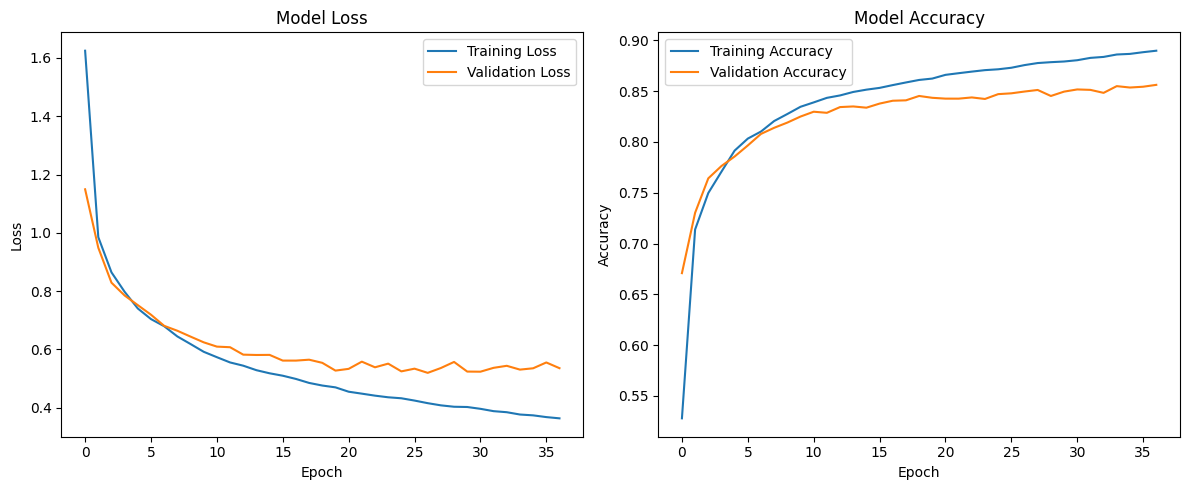

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
else:
    plt.title('Accuracy Not Available')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [12]:
def plot_prediction(sample_index):
    sample_image = X_val[sample_index][np.newaxis, ...]
    predicted_mask = model.predict(sample_image, verbose=0)
    predicted_mask = np.argmax(predicted_mask, axis=-1)[0]

    color_mask_predicted = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    color_mask_original = np.zeros((Y_val[sample_index].shape[0], Y_val[sample_index].shape[1], 3), dtype=np.uint8)

    for idx, row in labels_df.iterrows():
        color = eval(row['rgb'])
        color_mask_predicted[predicted_mask == row['id']] = color
        color_mask_original[Y_val[sample_index] == row['id']] = color

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[sample_index])
    plt.title("Sample Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(color_mask_original)
    plt.title("Original Mask")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(color_mask_predicted)
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

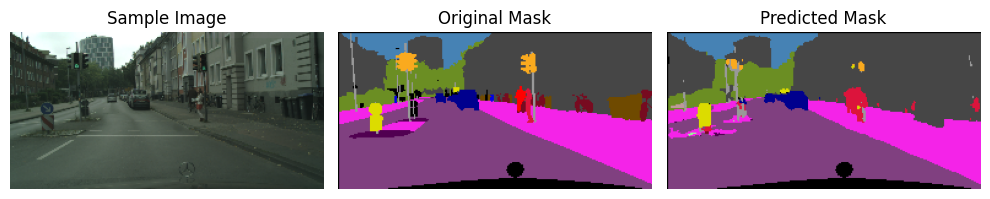

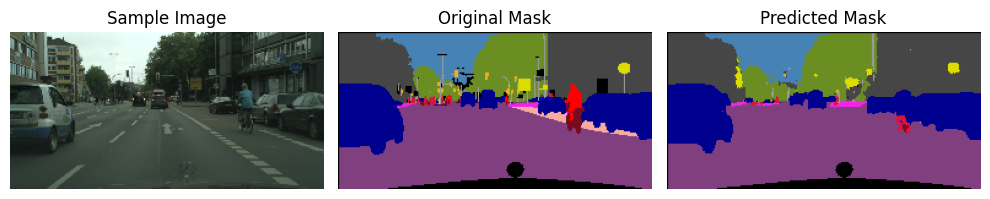

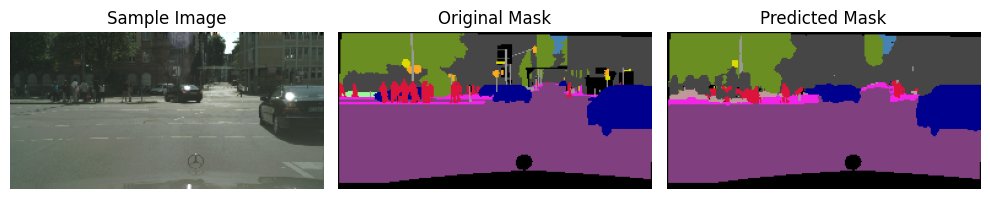

In [13]:
plot_prediction(10)
plot_prediction(50)
plot_prediction(300)

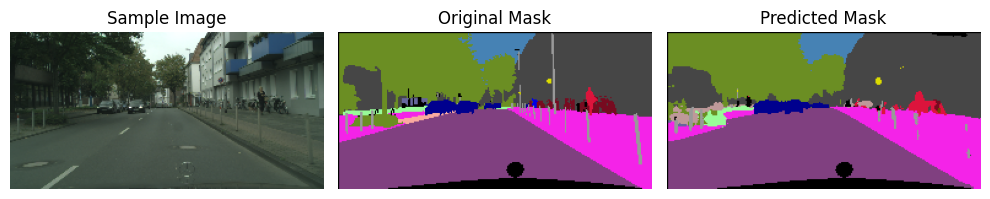

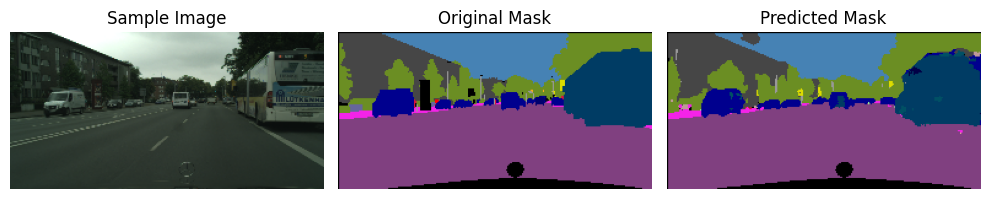

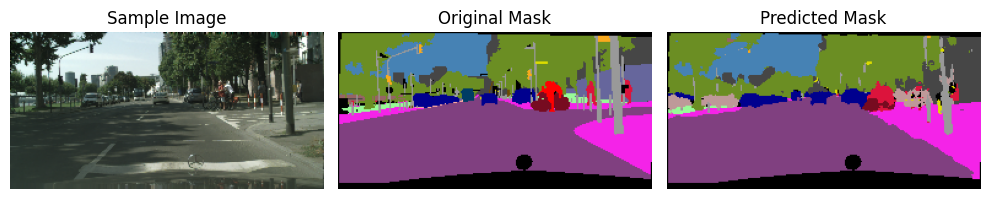

In [17]:
plot_prediction(20)
plot_prediction(150)
plot_prediction(450)

---

# TFLite Conversion

In [21]:
name = 'segmentation_model'
model_filepath = '/kaggle/working/'
os.makedirs(model_filepath, exist_ok=True)

model.export(model_filepath + f'/{name}')
converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(model_filepath + f'/{name}.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/kaggle/working//segmentation_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 128, 256, 29), dtype=tf.float32, name=None)
Captures:
  133504585785136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585784432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585788128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585787424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585844160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585844512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585845744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585845568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585852608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133504585852432: TensorSpec(shape=(), dtype=tf.resourc

W0000 00:00:1728254223.731554      30 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1728254223.731581      30 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [25]:
# load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=model_filepath + f'/{name}.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 128 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 128 256  29]
Output Type: <class 'numpy.float32'>


In [27]:
from tqdm import tqdm

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_tensor_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]['index'])

prediction_accuracy = []
for x, y in tqdm(zip(X_val, Y_val), total=len(X_val), desc="Evaluating model"):
    x = x[np.newaxis, ...].astype(np.float32)
    y = y[np.newaxis, ...].astype(np.int32)
    interpreter.set_tensor(input_tensor_index, x)
    interpreter.invoke()
    prediction = np.argmax(output()[0], axis=-1)
    prediction_accuracy.append(np.mean(prediction == y))

evaluation_accuracy = np.mean(prediction_accuracy)
print(f"Evaluation accuracy of the TFLite model: {evaluation_accuracy * 100:.2f}%")

Evaluating model: 100%|██████████| 500/500 [09:20<00:00,  1.12s/it]

Evaluation accuracy of the TFLite model: 84.97%


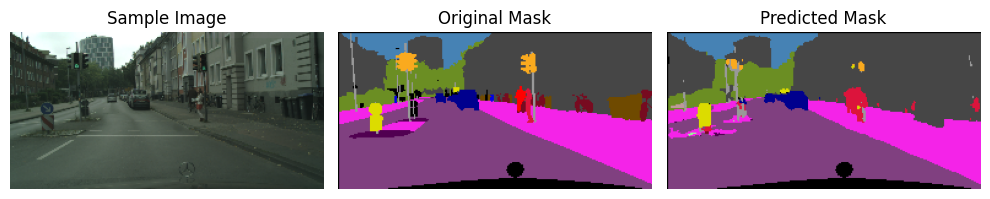

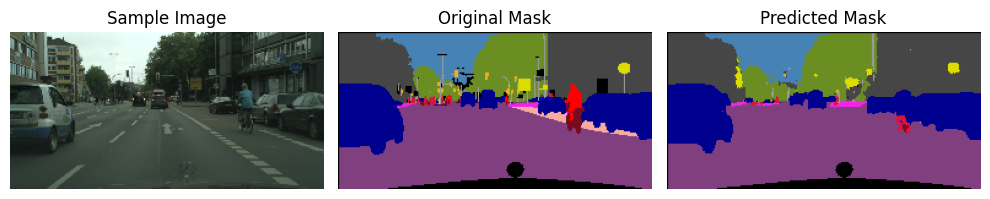

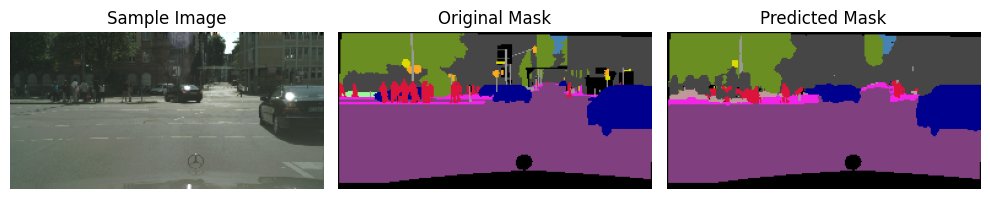

In [28]:
def plot_prediction_tflite(sample_index):
    sample_image = X_val[sample_index][np.newaxis, ...]
    interpreter.set_tensor(input_details[0]['index'], sample_image)
    interpreter.invoke()
    predicted_mask = np.argmax(interpreter.get_tensor(output_details[0]['index']), axis=-1)[0]

    color_mask_predicted = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    color_mask_original = np.zeros((Y_val[sample_index].shape[0], Y_val[sample_index].shape[1], 3), dtype=np.uint8)

    for idx, row in labels_df.iterrows():
        color = eval(row['rgb'])
        color_mask_predicted[predicted_mask == row['id']] = color
        color_mask_original[Y_val[sample_index] == row['id']] = color

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[sample_index])
    plt.title("Sample Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(color_mask_original)
    plt.title("Original Mask")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(color_mask_predicted)
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
 
plot_prediction_tflite(10)
plot_prediction_tflite(50)
plot_prediction_tflite(300)

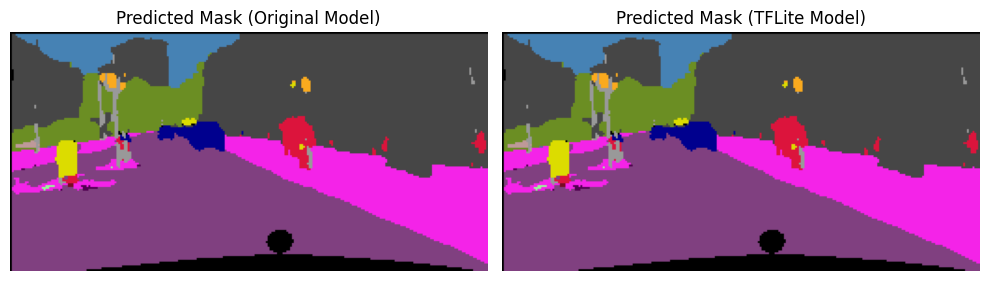

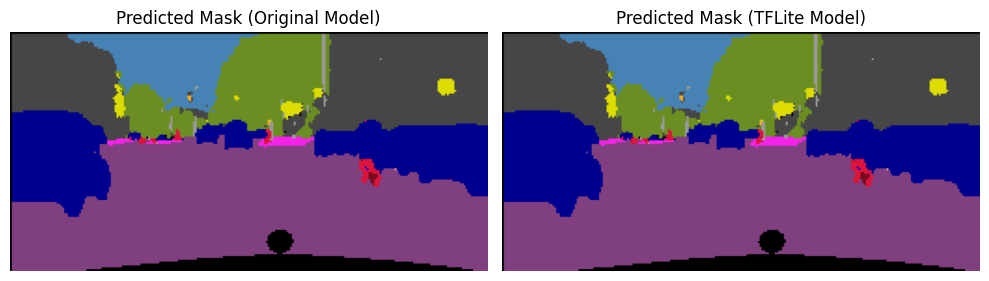

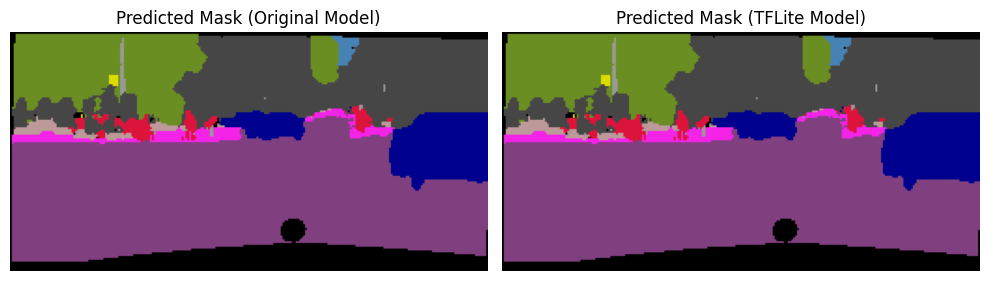

In [29]:
def plot_model_vs_tflite(sample_index):
    sample_image = X_val[sample_index][np.newaxis, ...]
    predicted_mask = model.predict(sample_image, verbose=0)
    predicted_mask = np.argmax(predicted_mask, axis=-1)[0]

    interpreter.set_tensor(input_details[0]['index'], sample_image)
    interpreter.invoke()
    predicted_mask_tflite = np.argmax(interpreter.get_tensor(output_details[0]['index']), axis=-1)[0]

    color_mask_predicted = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    color_mask_predicted_tflite = np.zeros((predicted_mask_tflite.shape[0], predicted_mask_tflite.shape[1], 3), dtype=np.uint8)

    for idx, row in labels_df.iterrows():
        color = eval(row['rgb'])
        color_mask_predicted[predicted_mask == row['id']] = color
        color_mask_predicted_tflite[predicted_mask_tflite == row['id']] = color

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(color_mask_predicted)
    plt.title("Predicted Mask (Original Model)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(color_mask_predicted_tflite)
    plt.title("Predicted Mask (TFLite Model)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
 
plot_model_vs_tflite(10)
plot_model_vs_tflite(50)
plot_model_vs_tflite(300)

---